In [29]:
import pylab
from pycbc import waveform
from pycbc import conversions

import numpy

from scipy import interpolate

def WaveformInterpolate (sampleTimes, sampleValues):
    interp = interpolate.splrep(sampleTimes, sampleValues, s=0)
    
    return interp

def OverlapPeriod (sampleTimes1, sampleTimes2):
    start1, end1 = sampleTimes1[0], sampleTimes1[-1]
    start2, end2 = sampleTimes2[0], sampleTimes2[-1]
    
    start = max([start1, start2])
    end = min([end1, end2])
    
    return start, end

def OverlapTimes (sampleTimes1, sampleTimes2, sampleRate):
    start, end = OverlapPeriod (sampleTimes1, sampleTimes2)
    
    overlapSampleTimes = [t for t in frange(start, end, 1.0/sampleRate)]
    
    return overlapSampleTimes
    
def frange(start, end, step):
    x = start

    while x < end:
        yield x
        x += step
        
def ApproxWaveform (approx, m1, m2, sampleRate, fLow, trimZeros=False):
    hp, hc = waveform.get_td_waveform(approximant=approx,
                                mass1=m1,
                                mass2=m2,
                                delta_t=1.0/sampleRate,
                                f_lower=fLow)
    
    if (trimZeros == True):
        hp, hc = hp.trim_zeros(), hc.trim_zeros()
        
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    f = waveform.utils.frequency_from_polarizations(hp, hc)
    
    return amp, f
        
def SubtractWaveforms (approx1, approx2, m1, m2, sampleRate, fLow):
    amp1, f1 = ApproxWaveform (approx1, m1, m2, sampleRate, fLow)
    amp2, f2 = ApproxWaveform (approx2, m1, m2, sampleRate, fLow)
    
    interp1 = WaveformInterpolate (f1.sample_times, f1)
    interp2 = WaveformInterpolate (f2.sample_times, f2)
    
    overlapSampleTimes = OverlapTimes (f1.sample_times, f2.sample_times, sampleRate)
    
    waveform1 = interpolate.splev(overlapSampleTimes, interp1, der=0)
    waveform2 = interpolate.splev(overlapSampleTimes, interp2, der=0)

#     pylab.plot(overlapSampleTimes, waveform1, label=approx1)
#     pylab.plot(overlapSampleTimes, waveform2, label=approx2)
    pylab.plot(overlapSampleTimes, numpy.absolute(waveform1 - waveform2), label="|" + approx1 + " - " + approx2 + "|")

    pylab.ylabel('Frequency (Hz)')
    pylab.xlabel('Time (s)')
    pylab.legend(loc='upper left')
    pylab.show()
    
f_low = 10
sample_rate = 2 * 4096

m1 = conversions.mass1_from_mtotal_q(100, 10)
m2 = conversions.mass2_from_mtotal_q(100, 10)

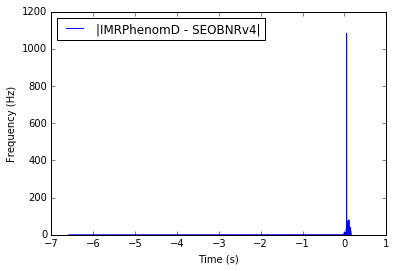

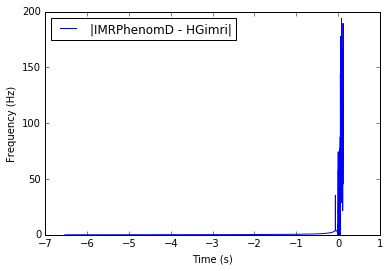

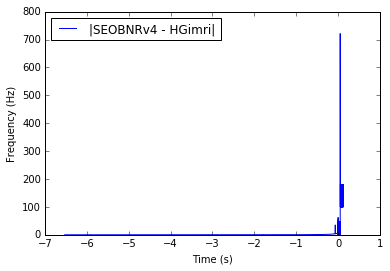

In [30]:
SubtractWaveforms ("IMRPhenomD", "SEOBNRv4", m1, m2, sample_rate, f_low)
SubtractWaveforms ("IMRPhenomD", "HGimri", m1, m2, sample_rate, f_low)
SubtractWaveforms ("SEOBNRv4", "HGimri", m1, m2, sample_rate, f_low)